In [1]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, store_param, transform, un_transform
from mpl_toolkits import mplot3d
# from matplotlib import cm
from alse.print_workflow.read_excel_fixed_feed import read_excel
from alse.print_workflow.init_model import initialize_models
from alse.one_iter_eci_fixed_feed import one_iter_eci
from alse.print_workflow.generate_test_points_fixed_feed import generate_test_points

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

Read data

In [3]:
X, width, pow_cap, adhere = read_excel()

Name for the excel sheets are hardcoded in this version
Spot size and feed rate are hardcoded in this version


In [4]:
import ipympl

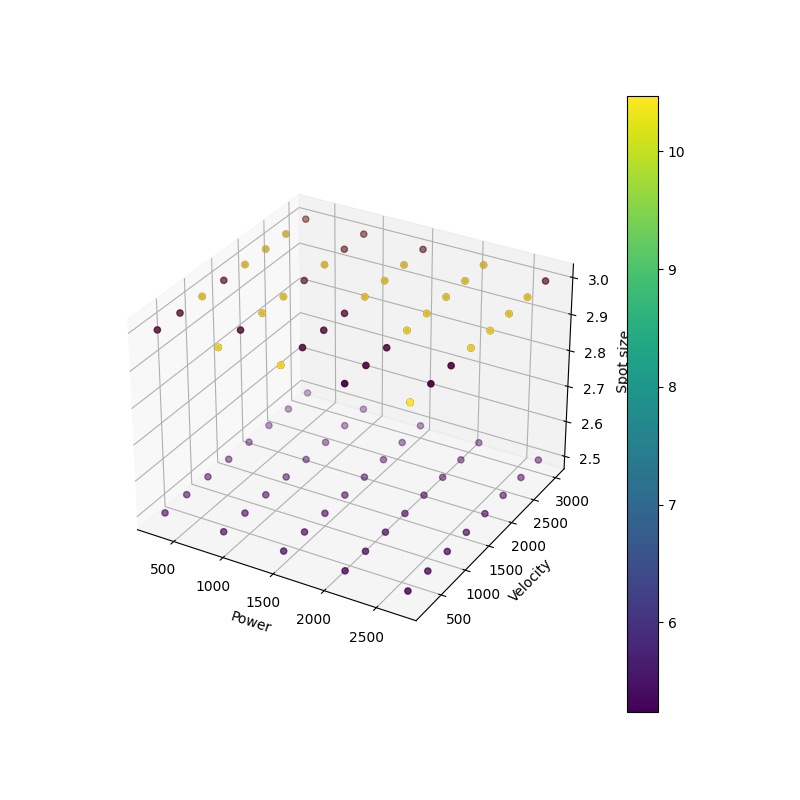

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
fig.colorbar(img)
plt.show()

In [6]:
# from mpl_toolkits.mplot3d import axes3d

In [7]:
# fig = plt.figure()
# ax = axes3d

# plot = ax.scatter(X[:,0], X[:,1], X[:,2])

In [8]:
# Store for un_transform later
xrange_list, xmin_list = store_param(X, 4)

In [9]:
X = transform(X, 4)

# You can verify the Normalization is correct by undoing the above step and comparing to original data
# X = un_transform(X, xrange_list, xmin_list, 4) 

In [10]:
list_of_models = initialize_models(X, width, pow_cap, adhere) # You can put in arbitrary amount of output parameters

C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [11]:
punchout_radius = 0.1
bounds = torch.tensor([[0, 0, 0, 0], [1, 1, 1, 1]], **tkwargs) # Because we normalized
lb, ub = bounds


In [12]:
constraints = [("gt", 0.3), ("gt", 20), ("gt", 0.1)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std

In [13]:
# How many new points do we want
num_pred = 4
Ytemp = [width, pow_cap, adhere] #Store temps for test point generation

In [14]:
X = generate_test_points(X, num_pred, Ytemp, constraints, punchout_radius, bounds)
X = un_transform(X, xrange_list, xmin_list, 4)

fixed features


C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


fixed features


C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


fixed features


C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


fixed features


C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [15]:
new_N_points = X[-num_pred:]
for i in range(new_N_points.shape[0], 0, -1):
    new_power = round(X[-i][0].item(), 2)
    new_velocity = round(X[-i][1].item(), 2)
    new_spotsize = round(X[-i][2].item(), 2)
    new_feedrate = round(X[-i][3].item(), 2)
    print(f"New X_{new_N_points.shape[0]+1-i}: Power: {new_power}W, Velocity: {new_velocity}mm/min, Spot size: {new_spotsize}mm, Feedrate: {new_feedrate}g/min")

New X_1: Power: 1046.44W, Velocity: 1716.0mm/min, Spot size: 2.6mm, Feedrate: 7.86g/min
New X_2: Power: 1798.91W, Velocity: 1019.32mm/min, Spot size: 2.84mm, Feedrate: 7.86g/min
New X_3: Power: 1062.35W, Velocity: 868.74mm/min, Spot size: 2.98mm, Feedrate: 7.86g/min
New X_4: Power: 1059.62W, Velocity: 907.35mm/min, Spot size: 2.88mm, Feedrate: 7.86g/min


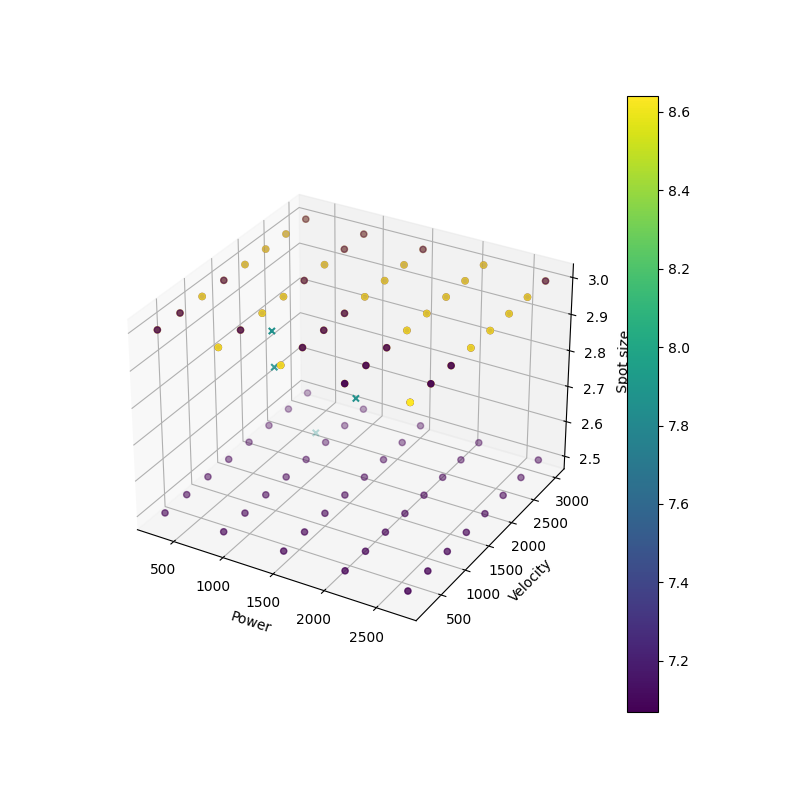

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:-num_pred,0], X[:-num_pred,1], X[:-num_pred,2], c=X[:-num_pred,3])
img = ax.scatter(X[-num_pred:,0], X[-num_pred:,1], X[-num_pred:,2], c=X[-num_pred:,3], marker = "x")
fig.colorbar(img)
plt.show()